In [2]:
#%matplotlib qt
%matplotlib inline
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
# RS: doubled checked 5/22/19
# magnification between first plane and considered plane, 
#dgammaErrFactor in HiCAT_APLCSP_spreadsheet in hicat_aplc repo
delta_gamma = 0.004

gamma_21 = 0.423
delta_gamma_21 = gamma_21 * delta_gamma

gamma_31 = 1.008
delta_gamma_31 =gamma_31 * delta_gamma

gamma_41 = 0.444
delta_gamma_41 = gamma_41 * delta_gamma

gamma_51 = 0.979
delta_gamma_51 = gamma_51 * delta_gamma
print(delta_gamma_21,delta_gamma_31,delta_gamma_41,delta_gamma_51)

0.001692 0.004032 0.001776 0.003916


# P2 - Iris AO

In [4]:
# RS: doubled checked 5/22/19

In [5]:
p2_irisao_segment_size = 1.4e-3 # m (note: point to point)
p2_irisao_segment_side_length = p2_irisao_segment_size / 2
p2_irisao_segment_gap_size = 12e-6 # m
#p2_irisao_segment_gap_size = 1.212e-3/10 # note: creating a DM where gaps = 1/10 segments, tested and working using DS9
p2_irisao_inscribed_circle_size = 10 * p2_irisao_segment_side_length
p2_irisao_flat_to_flat_size = 14 * np.sqrt(3) / 2 * p2_irisao_segment_side_length
p2_irisao_circumscribed_circle_size = np.sqrt(p2_irisao_flat_to_flat_size**2 + p2_irisao_segment_side_length**2)

print(p2_irisao_inscribed_circle_size)
print(p2_irisao_circumscribed_circle_size)
print(p2_irisao_flat_to_flat_size)

0.007
0.008515867542417507
0.008487048957087498


In [6]:
irisao_gap_hexagon_fraction = p2_irisao_segment_gap_size / p2_irisao_segment_side_length
print(irisao_gap_hexagon_fraction, 0.012 / 0.7)

0.017142857142857144 0.017142857142857144


In [7]:
p2_irisao_distance_between_segments = p2_irisao_segment_side_length * np.sqrt(3)
#corrected bug, sqrt(3) replaced by 2/sqrt(3)
# tested with this value for gap size==1/10 segment size; p2_irisao_segment_gap_size = 1.212e-3/10 (measurable in DS9)
p2_irisao_segment_circumdiameter = (2 * p2_irisao_segment_side_length) - (2/np.sqrt(3)) * p2_irisao_segment_gap_size
print(p2_irisao_segment_circumdiameter)

def p2_irisao():
    segment = hexagonal_aperture(p2_irisao_segment_circumdiameter, np.pi/2)
    
    segment_positions = make_hexagonal_grid(p2_irisao_distance_between_segments, 3, False)
    
    aperture = make_segmented_aperture(segment, segment_positions)
    return aperture

0.001386143593539449


# P1 - Pupil Mask

In [8]:
p1_pupil_mask_size = 19.850e-3 # m
p2_pupil_mask_size = p1_pupil_mask_size * gamma_21
print(p2_pupil_mask_size)

0.00839655


In [9]:
# Central segment
p1_pupil_mask_central_segment_size = 3.600e-3 # m
p2_pupil_mask_central_segment_size = p1_pupil_mask_central_segment_size * gamma_21
pupil_mask_central_segment_oversize_factor = p2_pupil_mask_central_segment_size / p2_irisao_segment_size
print(pupil_mask_central_segment_oversize_factor)

1.0877142857142856


In [10]:
# Spiders
p1_pupil_mask_spider_thickness = 0.200e-3 # m

In [11]:
pupil_mask_undersize_contour = p2_pupil_mask_size / p2_irisao_circumscribed_circle_size
print(pupil_mask_undersize_contour)

0.9859887977562841


In [12]:
# Output
print('Pupil mask side-to-side contour length in P1: %d um' % (p1_pupil_mask_size * 1e6))
print('Pupil mask central segment side length in P1: %d um' % (p1_pupil_mask_central_segment_size * 1e6))
print('Pupil mask spider thickness in P1: %d um' % (p1_pupil_mask_spider_thickness * 1e6))

Pupil mask side-to-side contour length in P1: 19850 um
Pupil mask central segment side length in P1: 3600 um
Pupil mask spider thickness in P1: 200 um


In [13]:
def p1_pupil_mask():
    segment = hexagonal_aperture(p1_pupil_mask_size / 7 / np.sqrt(3) * 2, np.pi / 2)
    distance_between_segments = p1_pupil_mask_size / 7
    segment_positions = make_hexagonal_grid(distance_between_segments, 3)
    contour = make_segmented_aperture(segment, segment_positions)
    
    central_segment = hexagonal_aperture(p1_pupil_mask_central_segment_size, np.pi / 2)
    
    spider1 = make_spider_infinite([0,0], 60, p1_pupil_mask_spider_thickness)
    spider2 = make_spider_infinite([0,0], 120, p1_pupil_mask_spider_thickness)
    spider3 = make_spider_infinite([0,0], -60, p1_pupil_mask_spider_thickness)
    spider4 = make_spider_infinite([0,0], -120, p1_pupil_mask_spider_thickness)
    
    def aper(grid):
        return (contour(grid) - central_segment(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    return aper

# P3 - Apodizer

In [14]:
# Contour
p3_apodizer_size = 19.725e-3 # m
p2_apodizer_size = p3_apodizer_size * gamma_21 / gamma_31
print(p2_apodizer_size)

0.008277455357142856


In [15]:
# Gap
p3_apodizer_mask_gap_size = 0.090e-3 # m
#p3_apodizer_mask_gap_size = 3*1.212e-3/10 *gamma_31 / gamma_21
p3_irisao_segment_gap_size = p2_irisao_segment_gap_size * gamma_31 / gamma_21
apodizer_mask_gap_oversize_factor_wrt_irisao = p3_apodizer_mask_gap_size / p3_irisao_segment_gap_size
print(p3_irisao_segment_gap_size)
print(apodizer_mask_gap_oversize_factor_wrt_irisao)

2.8595744680851065e-05
3.147321428571429


In [16]:
# Central segment
p3_apodizer_mask_central_segment_size = 3.950e-3 # m
p3_pupil_mask_central_segment_size = p1_pupil_mask_central_segment_size * gamma_31
apodizer_mask_central_segment_oversize_factor_wrt_pupil_mask = p3_apodizer_mask_central_segment_size / p3_pupil_mask_central_segment_size
p3_irisao_segment_size = p2_irisao_segment_size * gamma_31 / gamma_21


In [17]:
# Spiders
p3_apodizer_mask_spiders_thickness = 0.350e-3 # m

In [18]:
p3_irisao_segment_circumdiameter = p2_irisao_segment_circumdiameter * gamma_31 / gamma_21
p3_irisao_distance_between_segments = p2_irisao_distance_between_segments * gamma_31 / gamma_21
#corrected bug below, sqrt(3) replaced by 2/sqrt(3) Tested sucessefully using p3_apodizer_mask_gap_size = 3*1.212e-3/10 *gamma_31 / gamma_21
p3_apodizer_segment_circumdiameter = p3_irisao_segment_circumdiameter + (-p3_apodizer_mask_gap_size + p3_irisao_segment_gap_size) * (2/np.sqrt(3))

print(p3_irisao_distance_between_segments)

print(p3_apodizer_size / 7)

def p3_apodizer():
    # segmentation
    segment = hexagonal_aperture(p3_apodizer_segment_circumdiameter, np.pi/2)
    segment_positions = make_hexagonal_grid(p3_irisao_distance_between_segments, 3, False)
    segmentation = make_segmented_aperture(segment, segment_positions)
    
    segment = hexagonal_aperture(p3_apodizer_size / 7 / np.sqrt(3) * 2, np.pi / 2)
    distance_between_segments = p3_apodizer_size / 7
    segment_positions = make_hexagonal_grid(distance_between_segments, 3)
    contour = make_segmented_aperture(segment, segment_positions)
    
    central_segment = hexagonal_aperture(p3_apodizer_mask_central_segment_size, np.pi / 2)
    
    spider1 = make_spider_infinite([0,0], 60, p3_apodizer_mask_spiders_thickness)
    spider2 = make_spider_infinite([0,0], 120, p3_apodizer_mask_spiders_thickness)
    spider3 = make_spider_infinite([0,0], -60, p3_apodizer_mask_spiders_thickness)
    spider4 = make_spider_infinite([0,0], -120, p3_apodizer_mask_spiders_thickness)
    
    def aper(grid):
        return segmentation(grid) * (contour(grid) - central_segment(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    return aper

0.0028892081556042546
0.0028178571428571428


# P4 - Boston DM

In [19]:
p4_boston_dm_size = 9.9e-3 # m
num_actuators = 34
actuator_pitch = p4_boston_dm_size / num_actuators

In [20]:
p4_apodizer_size = p3_apodizer_size * gamma_41 / gamma_31
p4_irisao_circumscribed_circle_size = p2_irisao_circumscribed_circle_size * gamma_41 / gamma_21
p4_irisao_flat_to_flat_size = p2_irisao_flat_to_flat_size * gamma_41 / gamma_21

In [21]:
boston_dm_undersize_contour_wrt_apodizer_mask = p4_apodizer_size / p4_boston_dm_size
boston_dm_contour_oversize_factor = p4_boston_dm_size / p4_irisao_circumscribed_circle_size

print(boston_dm_undersize_contour_wrt_apodizer_mask)
print(boston_dm_contour_oversize_factor)

0.87761544011544
1.1075508995151944


In [22]:
num_actuators_used = boston_dm_undersize_contour_wrt_apodizer_mask * num_actuators
print(num_actuators_used)

29.83892496392496


In [23]:
print('Actuator pitch: %d um' % (actuator_pitch * 1e6))
print('Number of used actuators: %0.2f' % (num_actuators_used))

Actuator pitch: 291 um
Number of used actuators: 29.84


In [24]:
def p4_boston_dm():
    return circular_aperture(p4_boston_dm_size)

# P5 - Lyot stop

In [25]:
p5_lyot_stop_size = 15.9e-3 # m
p5_irisao_inscribed_circle_size = p2_irisao_inscribed_circle_size * gamma_51 / gamma_21
lyot_stop_mask_undersize_contour_wrt_inscribed_circle = p5_lyot_stop_size / p5_irisao_inscribed_circle_size

p5_irisao_flat_to_flat_size = p2_irisao_flat_to_flat_size * gamma_51 / gamma_21
p5_irisao_circumscribed_circle_size = p2_irisao_circumscribed_circle_size * gamma_51 / gamma_21
print(p5_irisao_circumscribed_circle_size)

0.019709301002427283


In [26]:
10 / (14 * np.sqrt(3) / 2) * lyot_stop_mask_undersize_contour_wrt_inscribed_circle

0.8094650321003662

In [27]:
# Central segment
p5_lyot_stop_mask_central_segment_size = 6.800e-3 # m
p5_apodizer_mask_central_segment_size = p3_apodizer_mask_central_segment_size * gamma_51 / gamma_31
print(p5_apodizer_mask_central_segment_size)
p5_irisao_segment_size = p2_irisao_segment_size * gamma_51 / gamma_21
lyot_stop_mask_central_segment_oversize_factor_wrt_apodizer_mask = p5_lyot_stop_mask_central_segment_size / p5_apodizer_mask_central_segment_size
print(lyot_stop_mask_central_segment_oversize_factor_wrt_apodizer_mask)

0.0038363591269841273
1.7725139318084842


In [28]:
# Spiders
p5_lyot_stop_mask_spiders_thickness = 0.700e-3 # m
lyot_stop_mask_spiders_thickness_ratio = p5_lyot_stop_mask_spiders_thickness / p5_irisao_circumscribed_circle_size
print(lyot_stop_mask_spiders_thickness_ratio)

0.03551622657311855


In [29]:
def p5_lyot_stop():
    outer_diameter = circular_aperture(p5_lyot_stop_size)
    central_obscuration = circular_aperture(p5_lyot_stop_mask_central_segment_size)
    
    spider1 = make_spider_infinite([0,0], 60, p5_lyot_stop_mask_spiders_thickness)
    spider2 = make_spider_infinite([0,0], 120, p5_lyot_stop_mask_spiders_thickness)
    spider3 = make_spider_infinite([0,0], -60, p5_lyot_stop_mask_spiders_thickness)
    spider4 = make_spider_infinite([0,0], -120, p5_lyot_stop_mask_spiders_thickness)
    
    def aper(grid):
        return (outer_diameter(grid) - central_obscuration(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    return aper

In [30]:
p5_lyot_stop_size

0.0159

In [31]:
p5_lyot_stop_mask_central_segment_size

0.0068

In [32]:
# Here the reference is plane P2 - but the largest size of the array is for the Boston DM (largest optic)
nPixelBostonDM = 500 
g = make_pupil_grid(nPixelBostonDM, p4_boston_dm_size / gamma_41 * gamma_21)
supersampling = 1

irisao = evaluate_supersampled(p2_irisao(), g, supersampling)
pupil_mask = evaluate_supersampled(p1_pupil_mask(), g.scaled(1 / gamma_21), supersampling)
apodizer = evaluate_supersampled(p3_apodizer(), g.scaled(gamma_31 / gamma_21), supersampling)
boston_dm = evaluate_supersampled(p4_boston_dm(), g.scaled(gamma_41 / gamma_21), supersampling)
lyot_stop = evaluate_supersampled(p5_lyot_stop(), g.scaled(gamma_51 / gamma_21), supersampling)

# debugging purposes: 
#write_fits(irisao, 'masks/irisao.fits')
#write_fits(apodizer, 'masks/apodizer.fits')

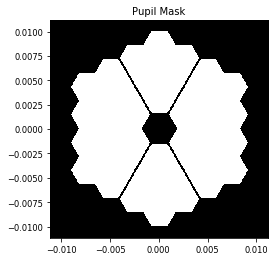

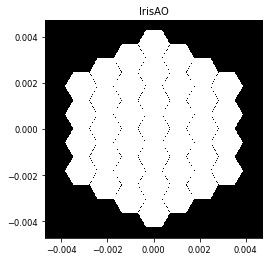

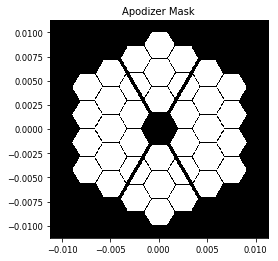

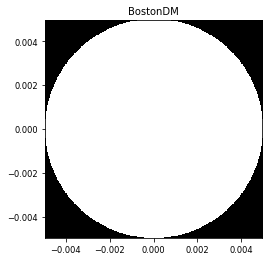

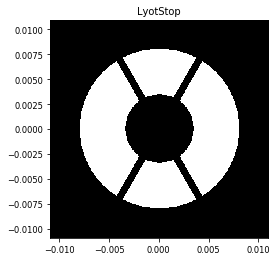

In [33]:
masks = [pupil_mask, irisao, apodizer, boston_dm, lyot_stop]
labels = ['Pupil Mask', 'IrisAO', 'Apodizer Mask', 'BostonDM', 'LyotStop']

for mask, label in zip(masks, labels):
    plt.figure()
    plt.title(label)
    imshow_field(mask, cmap='gray')
    plt.show()

In [34]:
# for i, (mask_a, label_a) in enumerate(zip(masks, labels)):
#    for j, (mask_b, label_b) in enumerate(zip(masks, labels)):
#        if j <= i:
#            continue
       
#        plt.figure()
#        plt.title(label_a + ' - ' + label_b)
#        imshow_field(mask_a - mask_b, cmap='gray', vmin=-1, vmax=1)
#        plt.show()

In [35]:
nPixApodizer = 2048;
magnification_tolerance = 0.000 # not investigated yet, in case we want to add robustness to magnification later
nlyotstops = 1 # for the magnification robustness 
gray_apod = False # because the apodizer defines the pupil (and oversizes all the structures) we don't want it gray
for gray in [True]:
    for num_pix in [nPixApodizer]:
        grid = make_uniform_grid(num_pix, [p3_apodizer_size, p3_apodizer_size])

        own_apod = evaluate_supersampled(p3_apodizer(), grid, 4 if gray_apod else 1)
        #write_fits(own_apod, 'masks/HiCAT/hicat_apodizer_mask_%d_%s.fits' % (num_pix, 'gy' if gray_apod else 'bw'))

        for mag_i, mag in enumerate(np.linspace(-magnification_tolerance/2, magnification_tolerance/2, nlyotstops)+1):
            print(mag * gamma_51 / gamma_31)
            print(mag)
            #own_lyot = evaluate_supersampled(p5_lyot_stop(), grid.scaled(mag * gamma_51 / gamma_31), 4 if gray else 1)
            #write_fits(own_lyot, 'masks/HiCAT/hicat_lyot_mask_%d_%s_%d.fits' % (num_pix, 'gy' if gray else 'bw', mag_i))

0.9712301587301587
1.0


In [36]:
#mathematica_apod = fits.getdata('masks/HiCAT/HiCAT-Aper_F-N0486_Hex3-Ctr0972-Obs0195-SpX0017-Gap0004.fits')
#own_apod = fits.getdata('masks/HiCAT/ehpor_hicat_apodizer_mask_486_bw_check_gap.fits')
#own_apod = fits.getdata('masks/HiCAT/hicat_apodizer_mask_486_gy.fits')
#diff = mathematica_apod-own_apod
#write_fits(diff,'masks/HiCAT/mathematica-epor.fits')
#plt.imshow(diff,cmap = 'Greys_r')
#plt.show()

In [37]:
#plt.subplot(1,2,1)
#imshow_field(own_apod, cmap='gray')
#plt.subplot(1,2,2)
#imshow_field(own_lyot, cmap='gray')
#plt.show()